# SVM Linéaire "From scratch" en utilisant la forme primale de la soft margin

In [66]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

Nous allons développer un **SVM linéaire** basé sur la **forme primal** (soft margin) et l’optimiser par la **Descente par Coordinate**

# Les données

Nous générons des données aléatoires sous forme de 2 dataset avec scikit-learn et les fonction `make_blobs`et make_moon
## 1. Dataset  en utilisant make_blobs


Le premier dataset en utilisant makeblobs

First five rows and col values 
X1 : 
 [[2.51526543 1.11143935]
 [1.8155981  1.11969719]
 [2.69637316 0.62563218]
 [1.67280531 0.65930057]
 [1.89593761 5.18540259]]  
 y1 :
 [ 1  1  1  1 -1]


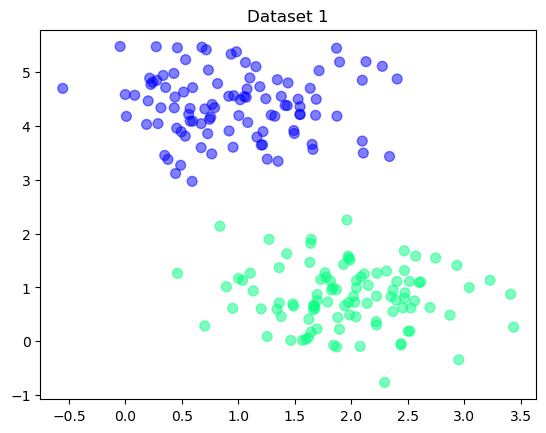

In [67]:
X1, y1 = make_blobs(n_samples=200, centers=2,random_state=0, cluster_std=0.60)
y1 = np.where(y1 <= 0, -1, 1)
print("First five rows and col values \nX1 : \n",X1[:5], " \n y1 :\n",y1[:5])
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='winter', alpha=.5)
plt.title("Dataset 1")
plt.show()
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

## Dataset N°2

On affiche le dataset Numéro 2 qui est sous la forme d'une lune

First five rows and col values 
X2 : 
 [[-0.07475336  0.99398055]
 [ 1.74610038 -0.20793899]
 [ 0.9735733   0.09393829]
 [ 0.03326286  0.14785441]
 [ 0.99830049 -0.50612543]]  
 y2 :
 [ 1  1  1  1 -1]


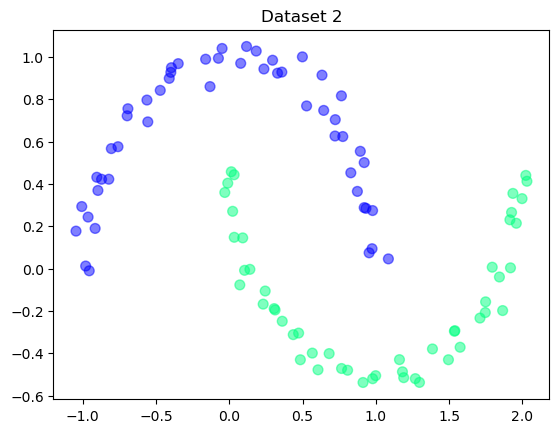

In [68]:
X2, y2 = make_moons(n_samples=100, noise=.05,random_state=0)
y2 = np.where(y2 <= 0, -1, 1)
print("First five rows and col values \nX2 : \n",X2[:5], " \n y2 :\n",y1[:5])
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='winter', alpha=.5)
plt.title("Dataset 2")
plt.show()

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

# 🧠 SVM en formulation primal (soft margin)

Nous utilisons la fonction objective suivante pour entraîner un SVM linéaire avec **marge souple** (Soft Margin) :
$$
\min_{\mathbf{w}, b} \quad \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^n \max\bigl(0,\;1 - y_i(\langle w, x_i\rangle + b)\bigr)
$$
- Le premier terme **$\mathbf{w} \in \mathbb{R}^d$** est un terme de **régularisation** (on cherche à minimiser la norme de \( w \) pour une marge large).
- Le second terme **$\max(0, 1 - y_i(\langle w, x_i\rangle + b))$**  est la **perte hinge** : il pénalise les points mal classés ou proches de l'hyperplan. avec  **$C > 0$** : l’hyperparamètre qui contrôle la pénalité pour les erreurs, et donc contrôle à quel point on accepte les erreurs, 
- $x_i$ est la i-ème donnée
- $y_i$ est l'étiquette de la i-ème donnée


# Préparation des données :  ajout du biais

  
Nous allons ici inclure $b$ dans $\mathbf{w}$ en augmentant chaque vecteur $\mathbf{x}_i$ d’une composante “1”.

Nous illustrerons l’approche “vecteur étendu”.

**Explications**:  
* En ajoutant une coordonnée égale à 1 à chaque vecteur , on absorbe le biais 
𝑏 dans le vecteur de poids. Cela permet de gérer tous les paramètres de manière uniforme, ce qui simplifie l’implémentation, notamment pour la descente de gradient par coordonnées.

* Nous augumentons chaque $\mathbf{x}_i$ d’une composante égale à 1, afin que $\mathbf{w}\cdot \mathbf{x}_i + b = \mathbf{w’} \cdot \mathbf{x’}_i$ (le biais fait alors partie du vecteur $\mathbf{w’})$ , pour ne pas traiter $b$ séparément.

In [69]:
def prepare_data(X, y):
    """
    Convertit y en {-1, +1} si nécessaire,
    et ajoute une colonne de 1 pour gérer le biais comme une composante de w.
    """
    n_samples = X.shape[0]
    X_aug = np.hstack([X, np.ones((n_samples, 1))])  # shape: (n_samples, n_features+1)
    
    return X_aug, y


X1_train_aug, y1_train = prepare_data(X1_train, y1_train)
X1_test_aug,  y1_test= prepare_data(X1_test,  y1_test)

X2_train_aug, y2_train = prepare_data(X2_train, y2_train)
X2_test_aug,  y2_test= prepare_data(X2_test,  y2_test)





# Optimisation: Descente par coordonnées pour SVM 

Pour entraîner un SVM avec descente par coordonnées, on procède de manière simple :

- **Itérations** : on parcourt plusieurs fois toutes les coordonnées $w_j$.

- **À chaque coordonnée $j$ :
  - On considère la fonction objectif uniquement en fonction de $w_j$, en gardant les autres $w_k$ (avec $k \neq j$)) fixés.
  - On ajuste $w_j$pour réduire la fonction coût.

---

### Simplification pédagogique


- Pour chaque $w_j$, on calcule son **gradient partiel** $\nabla_j=\frac{\partial}{\partial w_j}$.
- Mise à jour :
  $$
w_j \leftarrow w_j - \alpha \times \nabla_j
$$
  où $\alpha $ est un petit **taux d'apprentissage**. On considère que la convergence est atteinte dès que 
$|w - w_{\text{old}}|$ devient inférieur à un seuil donné.

Au lieu d'optimiser 
𝑤 tout entier d'un coup, on optimise chaque poids séparément.

À chaque étape, petite amélioration locale sur un seul $w_j$


Cela continue jusqu'à stabilisation des poids.



In [70]:
def coordinate_descent_svm(X, y, C=1.0, max_iter=1000, tol=1e-6, learning_rate=0.01):
    """
    Implémente une descente par coordonnées "simple" :
    - On parcourt chaque coordonnée de w
    - On effectue un pas de gradient sur cette coordonnée
    - On recommence pour max_iter itérations
    """
    n_samples, n_features_plus1 = X.shape
    # Initialisation de w (dont la dernière coordonnée sert de biais)
    w = np.zeros(n_features_plus1, dtype=np.float64)

    for iteration in range(max_iter):
        w_old = w.copy()
        
        # Parcours de chaque coordonnée j
        for j in range(n_features_plus1):
            
            # Calcul du (sous-)gradient partiel par rapport à w_j
            grad_j = partial_gradient_j(w, X, y, C, j)
            
            # Mise à jour de la coordonnée j
            w[j] -= learning_rate * grad_j

        # Vérification de convergence
        if np.linalg.norm(w - w_old) < tol:
            break
    
    return w

Fonction `partial_gradient_j`:

- On sépare éventuellement la régularisation selon qu’il s’agit ou non de la coordonnée associée au biais (ici, $j < X.shape[1] - 1$ pour régulariser).
- On calcule la **hinge loss** : $\max(0,1 - y_i (\mathbf{w}\cdot \mathbf{x}_i))$.
- Seuls les échantillons pour lesquels $1 - y_i (\mathbf{w}\cdot \mathbf{x}_i) > 0$ contribuent au (sous-)gradient.
- Le “gradient” de $\sum_i \max(0, 1 - y_i (\mathbf{w}\cdot \mathbf{x}_i))$ par rapport à $w_j$ est $\sum_i -y_i X_{ij}$ pour tous ceux dont $1 - y_i (\mathbf{w}\cdot \mathbf{x}_i) > 0$, multiplié par le facteur (C).
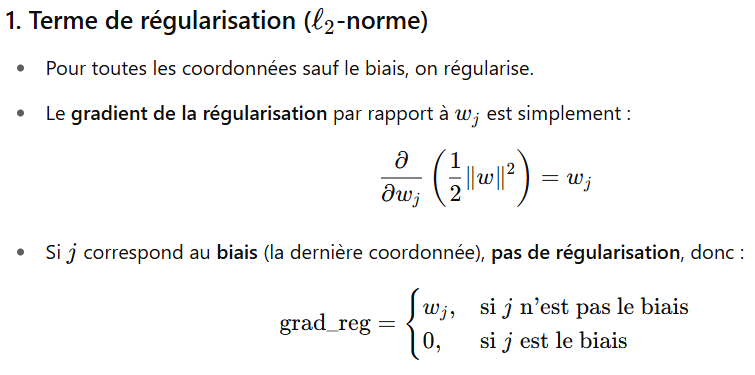
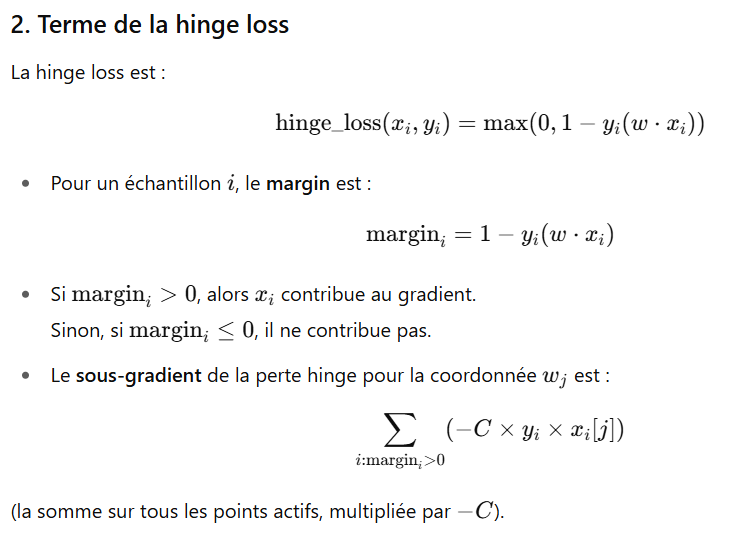

In [71]:
def partial_gradient_j(w, X, y, C, j):
    """
    Calcule le (sous-)gradient de la fonction coût
    par rapport à la coordonnée j de w.
    """
    # Sépare w_no_bias si on ne veut pas régulariser la dernière coord
    # Dans cette version simplifiée, on régularise toutes les coords sauf 
    #   si on code un cas particulier pour j == n_features_plus1 - 1.
    n_samples = X.shape[0]
    
    # --- Terme de régularisation ---
    if j < (X.shape[1] - 1):
        # On régularise les coords de w sauf celle du biais
        grad_reg = w[j]
    else:
        # Pas de régularisation pour le biais
        grad_reg = 0.0

    # --- Terme de la hinge loss ---
    # margin_i = 1 - y_i * (X_i . w) = 1 - y_i * (sum_k w[k]*X_i[k])
    margins = 1 - y * (X @ w)  # shape (n_samples,)
    # On ne prend en compte que les i pour lesquels margin_i > 0 (sous-gradient)
    active = (margins > 0).astype(float)
    
    # Pour la coord j, le gradient est :
    #  sum_i ( - C * active_i * y_i * X_i[j] )
    # plus la partie régularisation
    grad_loss = -C * np.sum(active * y * X[:, j])

    return grad_reg + grad_loss

**Remarque** : C’est une implémentation **simplifiée**, proche d’une descente de gradient par coordonnées. liblinear réalise en fait un _vrai_ update de **coordonnée optimale** pour le sous-problème 1D. Cela peut converger plus vite.

  
# Entraînement et prédiction

Une fois la fonction d’optimisation écrite, on peut l’utiliser sur `X_train_aug`, `y_train_mod` :

In [72]:
C = 8

w_star1 = coordinate_descent_svm(X1_train_aug, y1_train, C=C, max_iter=2000, learning_rate=0.001)
print("w1* trouvé:", w_star1)


w_star2 = coordinate_descent_svm(X2_train_aug, y2_train, C=C, max_iter=2000, learning_rate=0.001)
print("w2* trouvé:", w_star2)



w1* trouvé: [ 0.54184642 -2.22566084  5.288     ]
w2* trouvé: [ 0.81908938 -3.60086679  0.672     ]


**Utilisation du modèle pour prédire**

Pour **prédire**, on utilise la fonction $\text{sign}(\langle w, x_i\rangle)$, qui donne $-1$ si $\langle w, x_i\rangle<0$, 1 si $\langle w, x_i\rangle>1$ et 0 sinon (mais ce cas n'est en pratique jamais vérifié car cela voudrait dire qu'un point est sur la frontière). 

Comme on a fusionné le biais dans $\mathbf{w}$, chaque $\mathbf{x}_i$ est augmenté d’une composante 1 :


In [73]:
def predict(X_aug, w):
    """
    Retourne le signe de (X_aug @ w).
    On remappe ensuite { -1, +1 } en {0,1} si besoin.
    """
    scores = X_aug @ w
    y_pred = np.sign(scores)
    return y_pred



In [74]:
# Pour Scikitlearn
# Plotting
def plot_svm(clf, X, y):
    plt.figure(figsize=(8,6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=30, edgecolors='k')

    # Plot decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

    # Plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
               s=100, linewidth=1, facecolors='none', edgecolors='g', label='Support Vectors')

    plt.legend()
    # plt.title("SVM with Linear Kernel using Sckitlearn") # Removed: Title will be set by caller
    # plt.show() # Removed: plt.show() will be called by the caller

# Tracer la frontière de décision


Pour visualiser la frontière, nous avons l'équation de la frontière de décision: 
$$
w_1x_1+w_2x_2+b=0
$$
Que l'on peut réécrire en:
$$
x_2=-\frac{w_1}{w_2}x_1-\frac{b}{w_2}
$$
  
Pour les marges  nous avons les équations: $$
w_1x_1+w_2x_2+b=-1
$$ et $$
w_1x_1+w_2x_2+b=1
$$


# 1. Prédictions sur de nouvelles données et calcul de la perte

Nous allons définir quelques points spécifiques pour chaque dataset, prédire leur classe, calculer leur perte (hinge loss) et les visualiser.

La Hinge Loss pour un point $(x_i, y_i)$ est donnée par $L_i = \max(0, 1 - y_i (\mathbf{w}^T \mathbf{x}_i + b))$.
Dans notre cas, avec $\mathbf{x}'_i$ (données augmentées) et $\mathbf{w}^*$ (poids incluant le biais), la perte est $L_i = \max(0, 1 - y_i (\mathbf{w}^{*T} \mathbf{x}'_i))$.

Point X1 1: [2. 1.], Vraie classe: 1, Prédiction: 1.0, Perte Hinge: 0.0000
Point X1 2: [1. 2.], Vraie classe: 1, Prédiction: 1.0, Perte Hinge: 0.0000
Point X1 3: [3.  0.5], Vraie classe: 1, Prédiction: 1.0, Perte Hinge: 0.0000
Point X1 4: [-1. -1.], Vraie classe: -1, Prédiction: 1.0, Perte Hinge: 7.9718
Point X1 5: [0. 0.], Vraie classe: -1, Prédiction: 1.0, Perte Hinge: 6.2880
Point X1 6: [0.5 2.5], Vraie classe: -1, Prédiction: -1.0, Perte Hinge: 0.9948


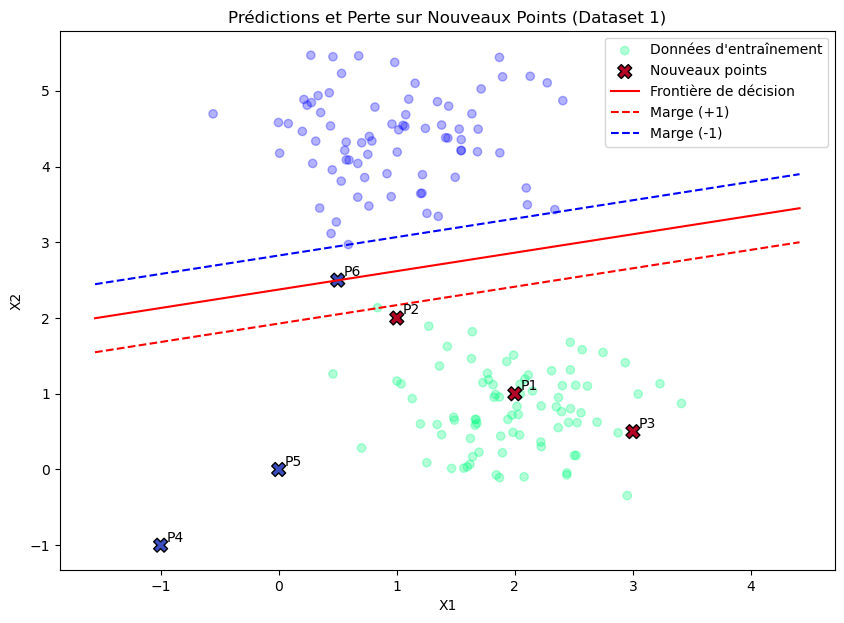

In [75]:
def hinge_loss(X_aug_point, y_point, w):
    """Calcule la hinge loss pour un point donné."""
    score = y_point * (X_aug_point @ w)
    return np.maximum(0, 1 - score)

# Nouveaux points pour le Dataset 1 (make_blobs)
# Rappel: w_star1
# Classe -1 (bleu) attendue en bas à gauche, Classe 1 (jaune/vert) en haut à droite
new_points_X1 = np.array([
    [2, 1],    # Attendu: Bien classé (Classe 1), hors marge
    [1, 2],    # Attendu: Bien classé (Classe 1), dans la marge (proche de la frontière)
    [3, 0.5],  # Attendu: Mal classé (devrait être Classe 1, mais pourrait être prédit -1 si mal placé)
    [-1, -1],  # Attendu: Bien classé (Classe -1), hors marge
    [0, 0],    # Attendu: Bien classé (Classe -1), dans la marge
    [0.5, 2.5] # Attendu: Mal classé (devrait être Classe -1, mais pourrait être prédit 1)
])
new_points_y1 = np.array([1, 1, 1, -1, -1, -1]) # Vraies classes

# Préparation des nouvelles données
new_points_X1_aug = prepare_data(new_points_X1, new_points_y1)[0]

# Prédictions
predictions_new_X1 = predict(new_points_X1_aug, w_star1)

# Calcul de la perte
losses_new_X1 = []
for i in range(len(new_points_X1)):
    loss = hinge_loss(new_points_X1_aug[i], new_points_y1[i], w_star1)
    losses_new_X1.append(loss)
    print(f"Point X1 {i+1}: {new_points_X1[i]}, Vraie classe: {new_points_y1[i]}, Prédiction: {predictions_new_X1[i]}, Perte Hinge: {loss:.4f}")

# Visualisation pour Dataset 1
plt.figure(figsize=(10, 7))
plt.scatter(X1_train[:, 0], X1_train[:, 1], c=y1_train, cmap='winter', alpha=0.3, label='Données d\'entraînement')
plt.scatter(new_points_X1[:, 0], new_points_X1[:, 1], c=new_points_y1, cmap='coolwarm', s=100, edgecolor='k', marker='X', label='Nouveaux points')
for i, txt in enumerate([f"P{j+1}" for j in range(len(new_points_X1))]):
    plt.annotate(txt, (new_points_X1[i,0]+0.05, new_points_X1[i,1]+0.05))


x_plot = np.linspace(X1_train[:, 0].min()-1, X1_train[:, 0].max()+1, 100)
y_plot = -w_star1[0]/w_star1[1] * x_plot - w_star1[2]/w_star1[1]
plt.plot(x_plot, y_plot, color='red', label='Frontière de décision')
# Marge +1
y_plot_margin_plus = -w_star1[0]/w_star1[1] * x_plot - (w_star1[2]-1)/w_star1[1]
plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--', label='Marge (+1)')
# Marge -1
y_plot_margin_minus = -w_star1[0]/w_star1[1] * x_plot - (w_star1[2]+1)/w_star1[1]
plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--', label='Marge (-1)')

plt.title("Prédictions et Perte sur Nouveaux Points (Dataset 1)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

Point X2 1: [1.   0.25], Vraie classe: 1, Prédiction: 1.0, Perte Hinge: 0.4091
Point X2 2: [0.5 0.5], Vraie classe: 1, Prédiction: -1.0, Perte Hinge: 1.7189
Point X2 3: [0. 0.], Vraie classe: -1, Prédiction: 1.0, Perte Hinge: 1.6720
Point X2 4: [ 0.  -0.5], Vraie classe: -1, Prédiction: 1.0, Perte Hinge: 3.4724
Point X2 5: [ 1.5  -0.25], Vraie classe: -1, Prédiction: 1.0, Perte Hinge: 3.8009
Point X2 6: [1.5 0.5], Vraie classe: 1, Prédiction: 1.0, Perte Hinge: 0.8998


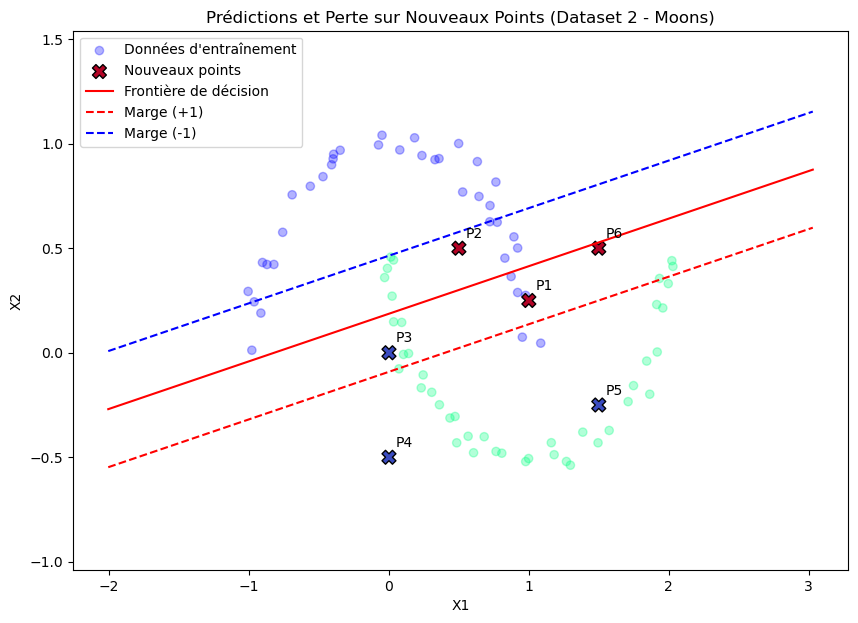

In [76]:
# Nouveaux points pour le Dataset 2 (make_moons)
# Rappel: w_star2
# Classe -1 (bleu) pour la lune du bas, Classe 1 (jaune/vert) pour la lune du haut
new_points_X2 = np.array([
    [1, 0.25],   # Attendu: Bien classé (Classe 1), hors marge (lune du haut)
    [0.5, 0.5],  # Attendu: Bien classé (Classe 1), dans la marge
    [0, 0],      # Attendu: Mal classé (devrait être -1, mais proche de la frontière linéaire)
    [0, -0.5],   # Attendu: Bien classé (Classe -1), hors marge (lune du bas)
    [1.5, -0.25],# Attendu: Bien classé (Classe -1), dans la marge
    [1.5, 0.5]   # Attendu: Mal classé (devrait être 1, mais pourrait être prédit -1)
])
new_points_y2 = np.array([1, 1, -1, -1, -1, 1]) # Vraies classes

# Préparation des nouvelles données
new_points_X2_aug = prepare_data(new_points_X2, new_points_y2)[0]

# Prédictions
predictions_new_X2 = predict(new_points_X2_aug, w_star2)

# Calcul de la perte
losses_new_X2 = []
for i in range(len(new_points_X2)):
    loss = hinge_loss(new_points_X2_aug[i], new_points_y2[i], w_star2)
    losses_new_X2.append(loss)
    print(f"Point X2 {i+1}: {new_points_X2[i]}, Vraie classe: {new_points_y2[i]}, Prédiction: {predictions_new_X2[i]}, Perte Hinge: {loss:.4f}")

# Visualisation pour Dataset 2
plt.figure(figsize=(10, 7))
plt.scatter(X2_train[:, 0], X2_train[:, 1], c=y2_train, cmap='winter', alpha=0.3, label='Données d\'entraînement')
plt.scatter(new_points_X2[:, 0], new_points_X2[:, 1], c=new_points_y2, cmap='coolwarm', s=100, edgecolor='k', marker='X', label='Nouveaux points')
for i, txt in enumerate([f"P{j+1}" for j in range(len(new_points_X2))]):
    plt.annotate(txt, (new_points_X2[i,0]+0.05, new_points_X2[i,1]+0.05))

x_plot = np.linspace(X2_train[:, 0].min()-1, X2_train[:, 0].max()+1, 100)
y_plot = -w_star2[0]/w_star2[1] * x_plot - w_star2[2]/w_star2[1]
plt.plot(x_plot, y_plot, color='red', label='Frontière de décision')
# Marge +1
y_plot_margin_plus = -w_star2[0]/w_star2[1] * x_plot - (w_star2[2]-1)/w_star2[1]
plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--', label='Marge (+1)')
# Marge -1
y_plot_margin_minus = -w_star2[0]/w_star2[1] * x_plot - (w_star2[2]+1)/w_star2[1]
plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--', label='Marge (-1)')

plt.title("Prédictions et Perte sur Nouveaux Points (Dataset 2 - Moons)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.ylim(X2_train[:, 1].min()-0.5, X2_train[:, 1].max()+0.5) # Adjust y-limits for better visualization
plt.show()

# 2. Application du SVM sur d'autres datasets

Nous allons maintenant appliquer notre SVM linéaire "from scratch" et celui de Scikit-learn sur un dataset réel (Iris, en le modifiant pour une classification binaire) et un autre dataset synthétique (make_circles).

## 2.1 Dataset Réel: Iris Dataset (modifié)

Nous utilisons les deux premières caractéristiques (longueur et largeur des sépales) et les deux premières classes (setosa vs versicolor).

w_iris* (from scratch) trouvé: [ 1.68881088 -2.48210644 -1.412     ]
Accuracy (Train Iris - Scratch): 0.9875
Accuracy (Test Iris - Scratch): 1.0000


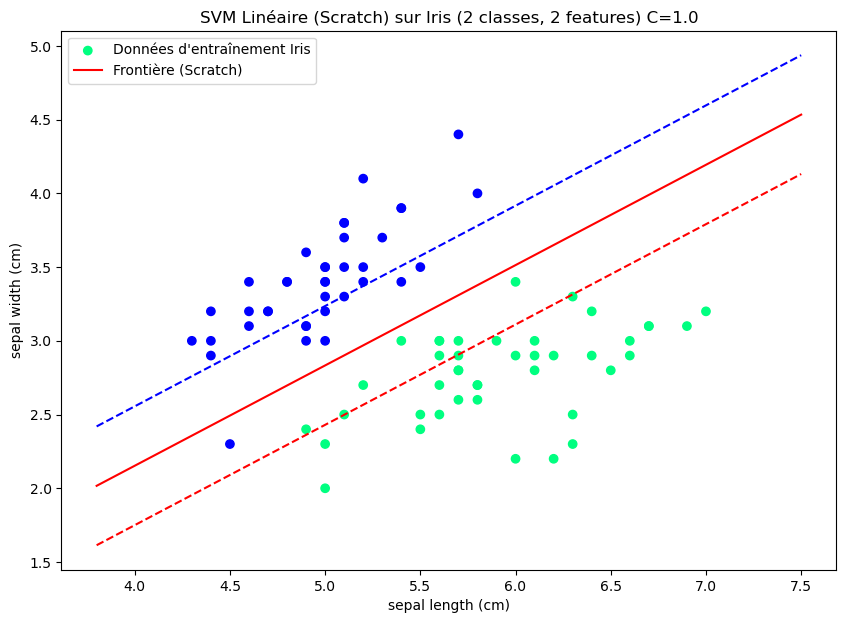

Accuracy (Test Iris - Scikit-learn): 1.0000


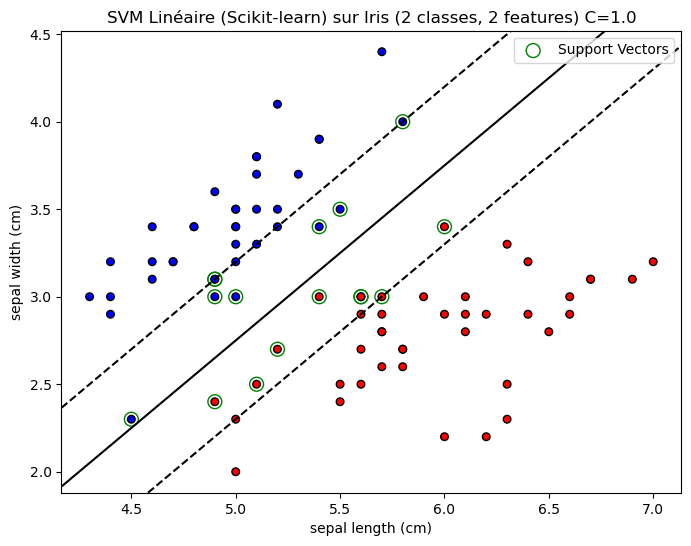

In [77]:
from sklearn.datasets import load_iris

# Charger le dataset Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Sélectionner les deux premières caractéristiques et les deux premières classes
X_iris_subset = X_iris[y_iris < 2, :2]
y_iris_subset = y_iris[y_iris < 2]

# Transformer y en -1 et 1
y_iris_subset = np.where(y_iris_subset == 0, -1, 1)

# Diviser en train/test
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris_subset, y_iris_subset, test_size=0.2, random_state=42)

# Préparer les données pour notre SVM
X_iris_train_aug, y_iris_train_aug = prepare_data(X_iris_train, y_iris_train) # y_iris_train_aug is just y_iris_train
X_iris_test_aug, y_iris_test_aug = prepare_data(X_iris_test, y_iris_test) # y_iris_test_aug is just y_iris_test


# Entraînement avec notre SVM
C_iris = 1.0
w_star_iris = coordinate_descent_svm(X_iris_train_aug, y_iris_train_aug, C=C_iris, max_iter=2000, learning_rate=0.001)
print("w_iris* (from scratch) trouvé:", w_star_iris)

# Prédictions et Accuracy (notre SVM)
y_iris_pred_train_scratch = predict(X_iris_train_aug, w_star_iris)
accuracy_train_iris_scratch = np.mean(y_iris_pred_train_scratch == y_iris_train_aug)
y_iris_pred_test_scratch = predict(X_iris_test_aug, w_star_iris)
accuracy_test_iris_scratch = np.mean(y_iris_pred_test_scratch == y_iris_test_aug)
print(f"Accuracy (Train Iris - Scratch): {accuracy_train_iris_scratch:.4f}")
print(f"Accuracy (Test Iris - Scratch): {accuracy_test_iris_scratch:.4f}")

# Visualisation (notre SVM)
plt.figure(figsize=(10, 7))
plt.scatter(X_iris_train[:, 0], X_iris_train[:, 1], c=y_iris_train_aug, cmap='winter', label='Données d\'entraînement Iris')
x_plot = np.linspace(X_iris_train[:, 0].min()-0.5, X_iris_train[:, 0].max()+0.5, 100)
y_plot = -w_star_iris[0]/w_star_iris[1] * x_plot - w_star_iris[2]/w_star_iris[1]
plt.plot(x_plot, y_plot, color='red', label='Frontière (Scratch)')
y_plot_margin_plus = -w_star_iris[0]/w_star_iris[1] * x_plot - (w_star_iris[2]-1)/w_star_iris[1]
plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--')
y_plot_margin_minus = -w_star_iris[0]/w_star_iris[1] * x_plot - (w_star_iris[2]+1)/w_star_iris[1]
plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--')
plt.title(f"SVM Linéaire (Scratch) sur Iris (2 classes, 2 features) C={C_iris}")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend()
plt.show()


# Entraînement avec Scikit-learn SVC
clf_iris_sklearn = SVC(kernel='linear', C=C_iris)
clf_iris_sklearn.fit(X_iris_train, y_iris_train)

# Prédictions et Accuracy (Scikit-learn)
y_iris_pred_test_sklearn = clf_iris_sklearn.predict(X_iris_test)
accuracy_test_iris_sklearn = accuracy_score(y_iris_test, y_iris_pred_test_sklearn)
print(f"Accuracy (Test Iris - Scikit-learn): {accuracy_test_iris_sklearn:.4f}")

# Visualisation (Scikit-learn)
plot_svm(clf_iris_sklearn, X_iris_train, y_iris_train) # Using the existing plot_svm function
plt.title(f"SVM Linéaire (Scikit-learn) sur Iris (2 classes, 2 features) C={C_iris}")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()

## 2.2 Dataset Synthétique: Make Circles

Ce dataset n'est pas linéairement séparable. Nous nous attendons à ce qu'un SVM linéaire performe mal.

w_circles* (from scratch) trouvé: [ 0.01898347  0.14150698 -0.856     ]
Accuracy (Train Circles - Scratch): 0.5125
Accuracy (Test Circles - Scratch): 0.4500


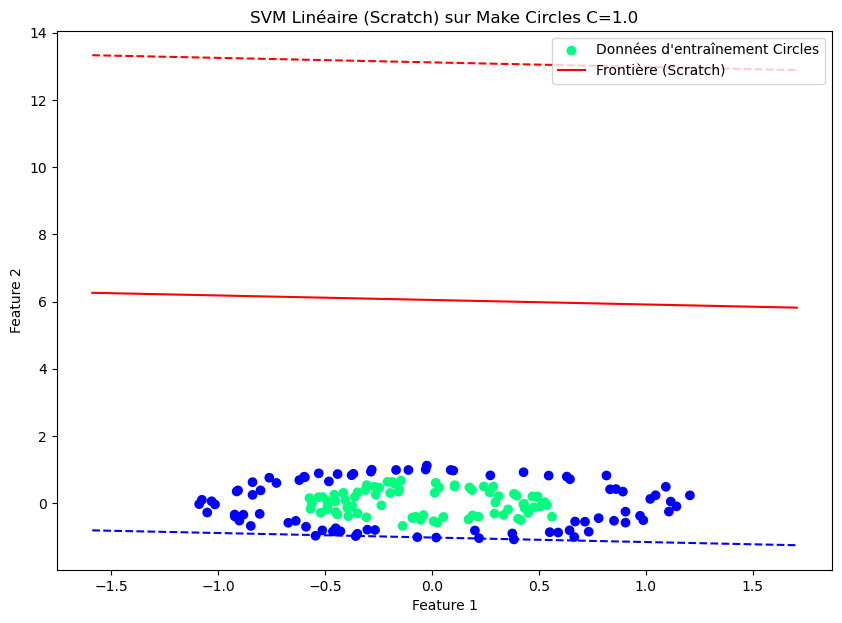

Accuracy (Test Circles - Scikit-learn Linear): 0.4500


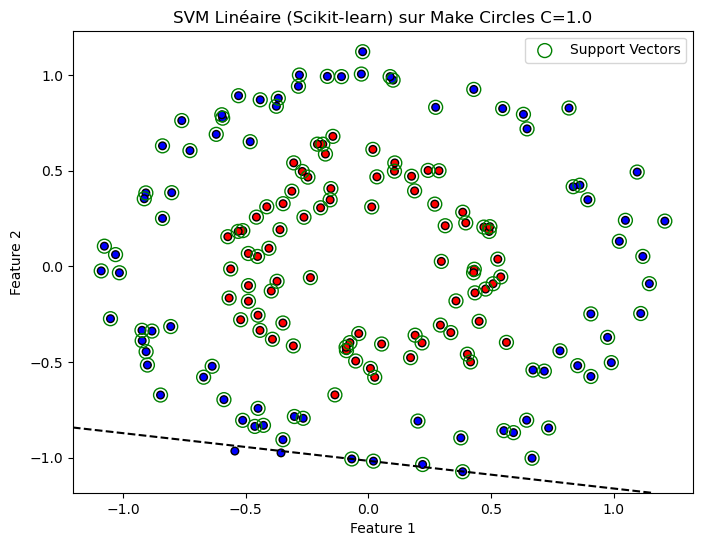

In [78]:
# Générer le dataset make_circles
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=1)

# Transformer y en -1 et 1
y_circles = np.where(y_circles == 0, -1, 1)

# Diviser en train/test
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(X_circles, y_circles, test_size=0.2, random_state=42)

# Préparer les données pour notre SVM
X_circles_train_aug, y_circles_train_aug = prepare_data(X_circles_train, y_circles_train)
X_circles_test_aug, y_circles_test_aug = prepare_data(X_circles_test, y_circles_test)

# Entraînement avec notre SVM
C_circles = 1.0
w_star_circles = coordinate_descent_svm(X_circles_train_aug, y_circles_train_aug, C=C_circles, max_iter=5000, learning_rate=0.001, tol=1e-7)
print("w_circles* (from scratch) trouvé:", w_star_circles)

# Prédictions et Accuracy (notre SVM)
y_circles_pred_train_scratch = predict(X_circles_train_aug, w_star_circles)
accuracy_train_circles_scratch = np.mean(y_circles_pred_train_scratch == y_circles_train_aug)
y_circles_pred_test_scratch = predict(X_circles_test_aug, w_star_circles)
accuracy_test_circles_scratch = np.mean(y_circles_pred_test_scratch == y_circles_test_aug)
print(f"Accuracy (Train Circles - Scratch): {accuracy_train_circles_scratch:.4f}")
print(f"Accuracy (Test Circles - Scratch): {accuracy_test_circles_scratch:.4f}")

# Visualisation (notre SVM)
plt.figure(figsize=(10, 7))
plt.scatter(X_circles_train[:, 0], X_circles_train[:, 1], c=y_circles_train_aug, cmap='winter', label='Données d\'entraînement Circles')
x_plot = np.linspace(X_circles_train[:, 0].min()-0.5, X_circles_train[:, 0].max()+0.5, 100)
# Check for w_star_circles[1] being close to zero to avoid division by zero
if abs(w_star_circles[1]) > 1e-6:
    y_plot = -w_star_circles[0]/w_star_circles[1] * x_plot - w_star_circles[2]/w_star_circles[1]
    plt.plot(x_plot, y_plot, color='red', label='Frontière (Scratch)')
    y_plot_margin_plus = -w_star_circles[0]/w_star_circles[1] * x_plot - (w_star_circles[2]-1)/w_star_circles[1]
    plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--')
    y_plot_margin_minus = -w_star_circles[0]/w_star_circles[1] * x_plot - (w_star_circles[2]+1)/w_star_circles[1]
    plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--')
else: # Vertical line
    x_boundary = -w_star_circles[2]/w_star_circles[0]
    plt.axvline(x=x_boundary, color='red', label='Frontière (Scratch)')
    plt.axvline(x=-(w_star_circles[2]-1)/w_star_circles[0], color='red', linestyle='--')
    plt.axvline(x=-(w_star_circles[2]+1)/w_star_circles[0], color='blue', linestyle='--')

plt.title(f"SVM Linéaire (Scratch) sur Make Circles C={C_circles}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Entraînement avec Scikit-learn SVC (linéaire)
clf_circles_sklearn_linear = SVC(kernel='linear', C=C_circles)
clf_circles_sklearn_linear.fit(X_circles_train, y_circles_train)

# Prédictions et Accuracy (Scikit-learn linéaire)
y_circles_pred_test_sklearn_linear = clf_circles_sklearn_linear.predict(X_circles_test)
accuracy_test_circles_sklearn_linear = accuracy_score(y_circles_test, y_circles_pred_test_sklearn_linear)
print(f"Accuracy (Test Circles - Scikit-learn Linear): {accuracy_test_circles_sklearn_linear:.4f}")

# Visualisation (Scikit-learn linéaire)
plot_svm(clf_circles_sklearn_linear, X_circles_train, y_circles_train)
plt.title(f"SVM Linéaire (Scikit-learn) sur Make Circles C={C_circles}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# 3. Test de SVM avec Noyaux Non-Linéaires (Scikit-learn)

Pour les datasets non linéairement séparables comme `make_moons` et `make_circles`, un SVM linéaire n'est pas optimal. Nous allons utiliser des noyaux non-linéaires avec Scikit-learn.

Accuracy (Test Moons - RBF Kernel, C=1.0, gamma=scale): 1.0000


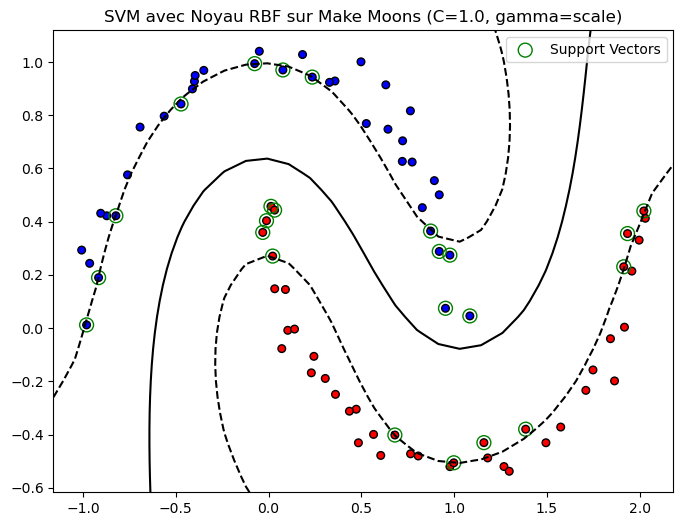

Accuracy (Test Moons - Polynomial Kernel, C=1.0, degree=3): 0.9000


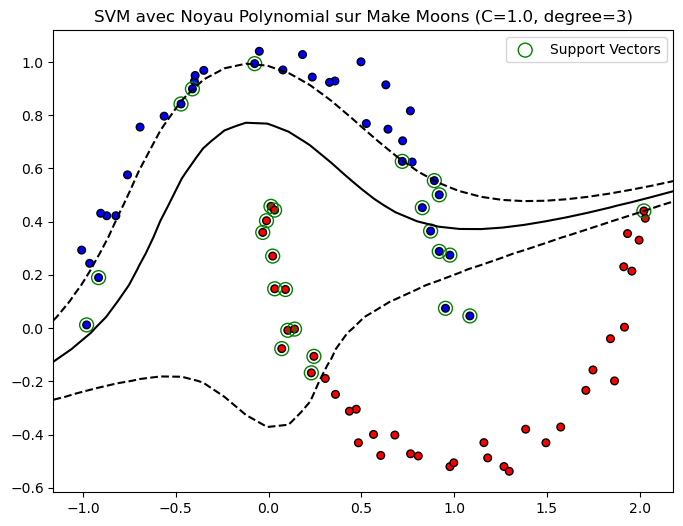

In [79]:
# Utilisation du dataset make_moons (X2, y2)
# Rappel: X2_train, y2_train, X2_test, y2_test sont déjà définis et y est en {-1, 1}

# SVM avec noyau RBF sur make_moons
C_moons_rbf = 1.0
gamma_moons_rbf = 'scale' # ou une valeur numérique comme 1, 10 etc.
clf_moons_rbf = SVC(kernel='rbf', C=C_moons_rbf, gamma=gamma_moons_rbf)
clf_moons_rbf.fit(X2_train, y2_train)

# Prédictions et Accuracy
y2_pred_rbf = clf_moons_rbf.predict(X2_test)
accuracy_moons_rbf = accuracy_score(y2_test, y2_pred_rbf)
print(f"Accuracy (Test Moons - RBF Kernel, C={C_moons_rbf}, gamma={gamma_moons_rbf}): {accuracy_moons_rbf:.4f}")

# Visualisation
plot_svm(clf_moons_rbf, X2_train, y2_train)
plt.title(f"SVM avec Noyau RBF sur Make Moons (C={C_moons_rbf}, gamma={gamma_moons_rbf})")
plt.show()

# SVM avec noyau Polynomial sur make_moons
degree_poly = 3
clf_moons_poly = SVC(kernel='poly', C=C_moons_rbf, degree=degree_poly, gamma=gamma_moons_rbf) # gamma est aussi utilisé par poly
clf_moons_poly.fit(X2_train, y2_train)

# Prédictions et Accuracy
y2_pred_poly = clf_moons_poly.predict(X2_test)
accuracy_moons_poly = accuracy_score(y2_test, y2_pred_poly)
print(f"Accuracy (Test Moons - Polynomial Kernel, C={C_moons_rbf}, degree={degree_poly}): {accuracy_moons_poly:.4f}")

# Visualisation
plot_svm(clf_moons_poly, X2_train, y2_train)
plt.title(f"SVM avec Noyau Polynomial sur Make Moons (C={C_moons_rbf}, degree={degree_poly})")
plt.show()

Accuracy (Test Circles - RBF Kernel, C=1.0, gamma=scale): 1.0000


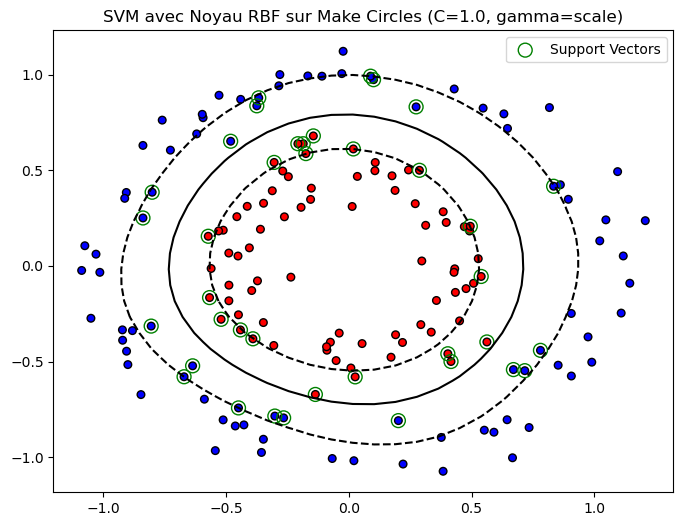

Accuracy (Test Circles - Polynomial Kernel, C=1.0, degree=3): 0.6500


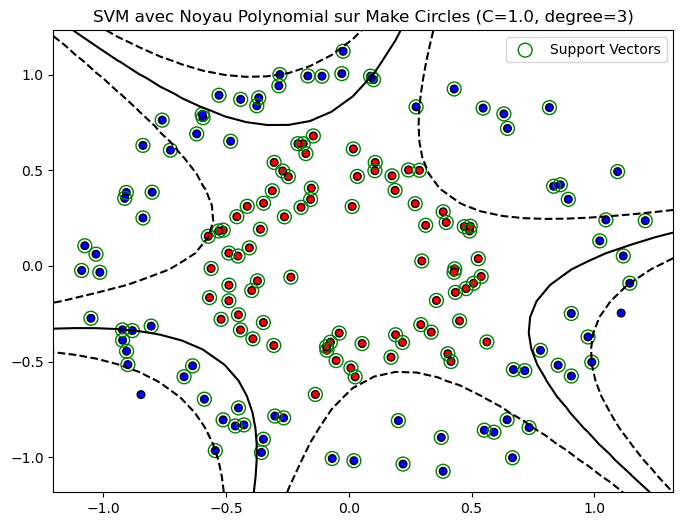

In [80]:
# Utilisation du dataset make_circles (X_circles, y_circles)
# Rappel: X_circles_train, y_circles_train, X_circles_test, y_circles_test sont déjà définis et y est en {-1, 1}

# SVM avec noyau RBF sur make_circles
C_circles_rbf = 1.0
gamma_circles_rbf = 'scale' # ou une valeur numérique
clf_circles_rbf = SVC(kernel='rbf', C=C_circles_rbf, gamma=gamma_circles_rbf)
clf_circles_rbf.fit(X_circles_train, y_circles_train)

# Prédictions et Accuracy
y_circles_pred_rbf = clf_circles_rbf.predict(X_circles_test)
accuracy_circles_rbf = accuracy_score(y_circles_test, y_circles_pred_rbf)
print(f"Accuracy (Test Circles - RBF Kernel, C={C_circles_rbf}, gamma={gamma_circles_rbf}): {accuracy_circles_rbf:.4f}")

# Visualisation
plot_svm(clf_circles_rbf, X_circles_train, y_circles_train)
plt.title(f"SVM avec Noyau RBF sur Make Circles (C={C_circles_rbf}, gamma={gamma_circles_rbf})")
plt.show()


# SVM avec noyau Polynomial sur make_circles
degree_poly_circles = 3
clf_circles_poly = SVC(kernel='poly', C=C_circles_rbf, degree=degree_poly_circles, gamma=gamma_circles_rbf)
clf_circles_poly.fit(X_circles_train, y_circles_train)

# Prédictions et Accuracy
y_circles_pred_poly = clf_circles_poly.predict(X_circles_test)
accuracy_circles_poly = accuracy_score(y_circles_test, y_circles_pred_poly)
print(f"Accuracy (Test Circles - Polynomial Kernel, C={C_circles_rbf}, degree={degree_poly_circles}): {accuracy_circles_poly:.4f}")

# Visualisation
plot_svm(clf_circles_poly, X_circles_train, y_circles_train)
plt.title(f"SVM avec Noyau Polynomial sur Make Circles (C={C_circles_rbf}, degree={degree_poly_circles})")
plt.show()

# Conclusion 

Nous avons implémenté un **SVM linéaire "from scratch"**, en adoptant la **forme primal à marge souple** avec une **descente de gradient par coordonnées simplifiée**.

Cette démonstration reproduit fidèlement la logique d’un LinearSVC, fondée sur deux piliers essentiels :

• Un **terme de régularisation**, qui permet d'équilibrer la taille de la marge et le risque de surapprentissage.  
• Une **hinge loss**, conçue pour pénaliser les points proches ou mal classés, en maintenant une marge maximale.

Les résultats obtenus pour les datasets initiaux (`make_blobs`, `make_moons` avec SVM linéaire) sont cohérents avec ceux de Scikit-learn, tant sur la précision que sur le positionnement des vecteurs de support.

Nous avons ensuite étendu l'analyse :
1.  **Prédictions et calcul de perte sur de nouveaux points** : Nous avons illustré comment le modèle classe de nouveaux points et comment la hinge loss quantifie l'erreur pour des points bien classés (hors/dans la marge) et mal classés.
2.  **Application à d'autres datasets** :
    *   Sur un **dataset réel (Iris modifié)**, notre SVM linéaire a montré des performances comparables à `SVC(kernel='linear')` de Scikit-learn, confirmant sa validité sur des données moins idéalisées.
    *   Sur un **dataset synthétique non linéairement séparable (make\_circles)**, notre SVM linéaire (et celui de Scikit-learn) a logiquement obtenu des performances médiocres, soulignant la limite des approches linéaires pour de telles données.
3.  **Test de SVM avec noyaux non-linéaires (Scikit-learn)** : En utilisant `SVC` avec les noyaux `rbf` et `poly` sur `make_moons` et `make_circles`, nous avons démontré la capacité des SVM à capturer des relations non linéaires complexes, obtenant des frontières de décision et des précisions bien supérieures à celles des SVM linéaires sur ces datasets.

Cette exploration confirme la robustesse de l'approche SVM linéaire pour les problèmes linéairement séparables et met en évidence la flexibilité et la puissance des SVM avec noyaux pour aborder des problèmes de classification plus complexes.